In [246]:
from sympy import *
from IPython.display import display
from misc import find_arg, to_single_sine

<img src="res/filter_disturbed.jpg" width="400">

In [247]:
A,A_dist,L,C,R,f,f_dist,t = symbols('A,A_dist,L,C,R,f,f_dist,t', positive = True)
q = Function('q')(t)
q_ = Derivative(q, t)
q__ = Derivative(q_, t)
args = [
    (A, 4),
    (A_dist, 2),
    (L, Rational(1, 10**3)),
    (C, Rational(1, 10**7)),
    (R, 120),
    (f, 10 * 10**3),
    (f_dist, 160),
]
# Distortions configured for about 240 rpm.
args_no_L = list(filter(lambda x : x[0] != L, args))
L_min = 0
L_max = 2e-3

In [248]:
U_s = A*sin(2*pi*f*t)
V_c = q/C
V_r = q_*R
V_l = q__*L
V_x = A_dist*sin(2*pi*f_dist*t)
eq = V_l + V_x + V_c + V_r - U_s
q_sol = dsolve(eq).rhs
to_erase = q_sol.free_symbols
to_erase.difference_update({A,A_dist,L,C,R,f,f_dist,t})
for s in to_erase:
    print('Erasing:', s)
    q_sol = q_sol.subs(s, 0)
U_f = U_s - L * q_sol.diff(t,2) - q_sol/C - V_x

Erasing: C1
Erasing: C2


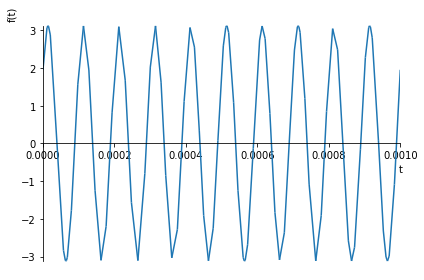

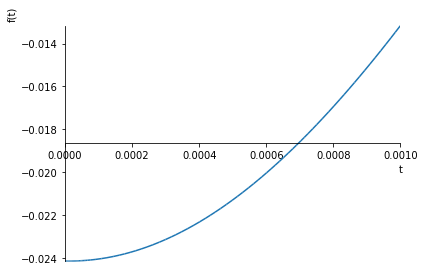

In [249]:
ex = U_f.expand()
parts = dict()
for term in ex.args:
    idx = find_arg(term, sin) or find_arg(term, cos)
    parts.setdefault(idx, 0)
    parts[idx] += term
phases = dict()
U_f_ng = 0
for x in parts.items():
    plot(x[1].subs(args), (t, 0, 1e-3))
    if x[0]:
        ss = to_single_sine(x[1])
        phases.setdefault(x[0], ss['phase'])
        U_f_ng += ss['func']
    if x[0] == None:
        U_f_ng += x[1]

In [250]:
for v in phases.values():
    display(v)

-atan((2*pi*L*f - 1/(2*pi*C*f))/R)

-atan((2*pi*L*f_dist - 1/(2*pi*C*f_dist))/R)

In [251]:
def get_ampl(expr):
    ss = to_single_sine(expr)['func']
    amplitude = abs(ss.subs(sin(find_arg(ss)), 1))
    return amplitude
for x in parts.items():
    print('freq =', (x[0]/2/pi/t).subs(args), '; ampl =', float(get_ampl(x[1]).subs(args)))

freq = 10000 ; ampl = 3.11937413447443
freq = 160 ; ampl = 0.024128114246511116


In [252]:
mot_ampl = 0.024 # motor noise ampl
sig_ampl = 3.11  # signal ampl
eq = (A*sin(2*pi*f*t) + mot_ampl).subs(A, sig_ampl).subs(args)
drift = solve(eq, t)[0] - 1/f.subs(args)/2
print('LF induced drift:', drift * 1e6, 'us')

LF induced drift: 0.122821753944354 us


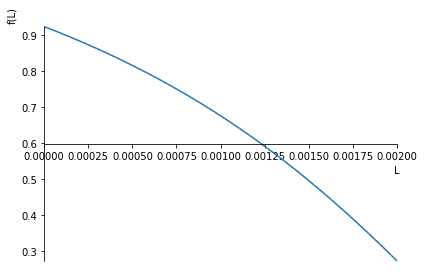

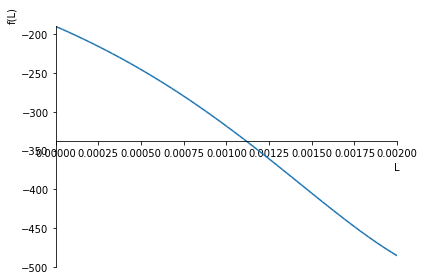

-318.42970394768577


In [253]:
plot(phases[2*pi*f*t].subs(args_no_L), (L,L_min,L_max))
plot(phases[2*pi*f*t].subs(args_no_L).diff(L), (L,L_min,L_max))
print(float(phases[2*pi*f*t].diff(L).subs(args)))

In [254]:
float(phases[2*pi*f*t].diff(L).subs(args))

-318.42970394768577

So, we can say that ```'additional phase shift' ~= 300 * 'additional inductance'```.
But how much is that in terms of time?
```'additional time shift' ~= ``` $300 / ({2 \pi  f})$ ``` * 'additional inductance'```

Seems that in our current motor inductance varies by about ```0.2 uH``` around the center, which is about ```1 uH```
 